In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [26]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [2]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [3]:
cleansed.count().count()

123

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:43: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:45: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:47: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:47: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:50: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

Idea:

* Sort portfolios on an annual baisis
* cacluated $\sigma$, $\mu$, skew, max drawdown

* Need to creat panel data and start running regression on that.  

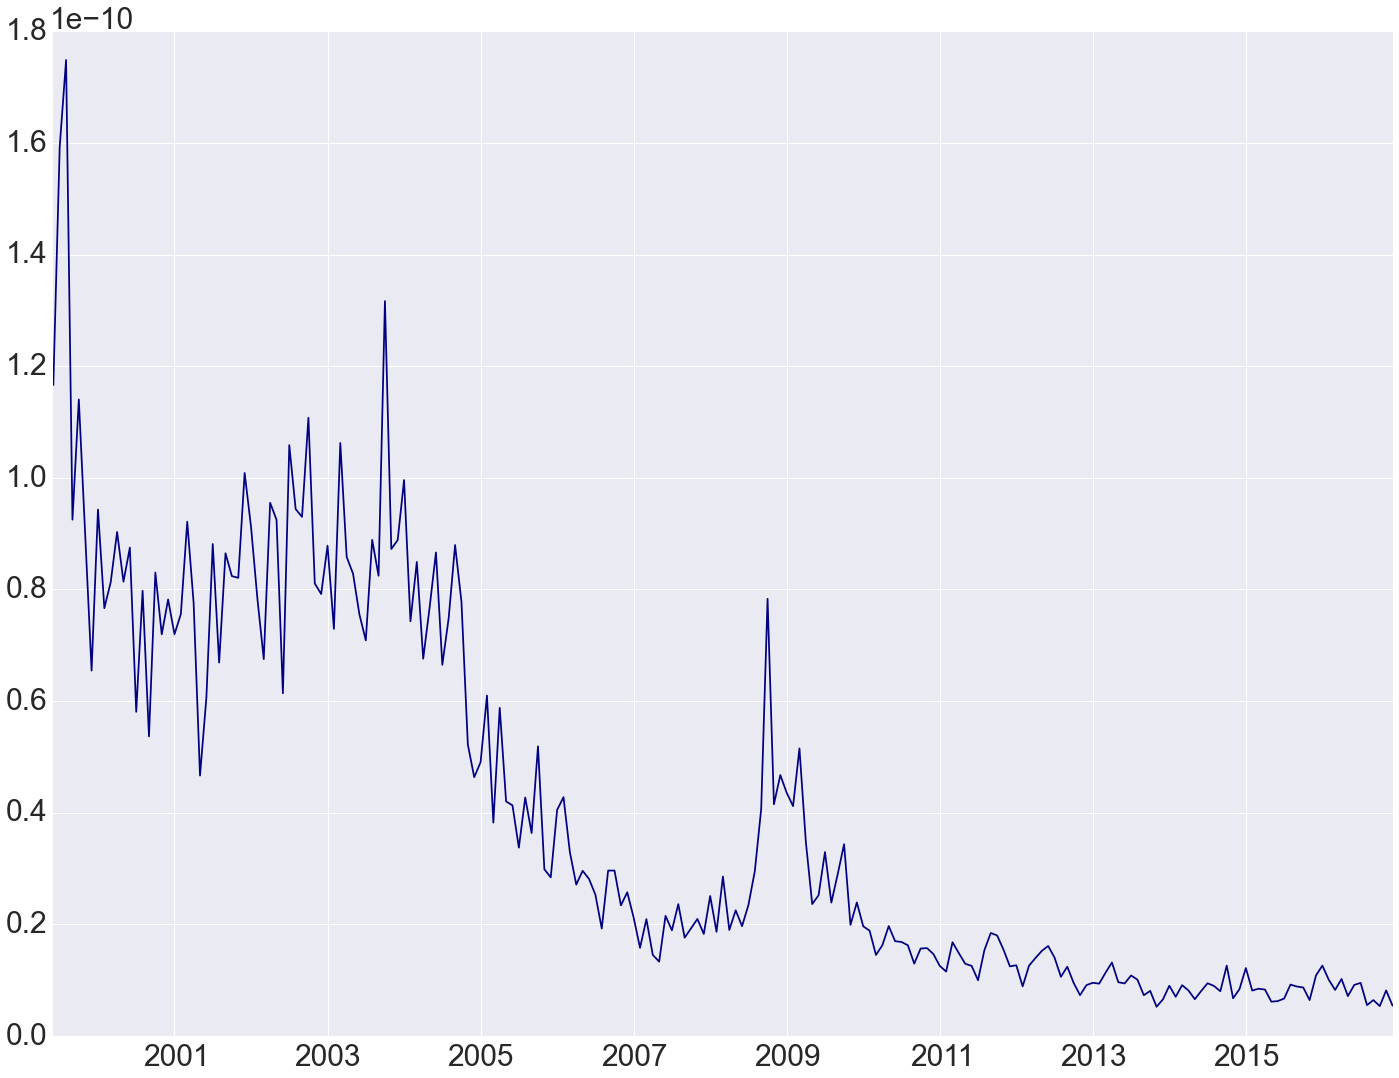

In [27]:
amihud.median(axis=1).dropna().plot(colormap='jet')

In [6]:
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
df=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
df['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


# Further undersanding liquidity factor

The further paper is trying to understand why do less liquid markets create this factor.  

The other state variables:
* Amihud (MKTILLIQ)
* LIBOR
* Fed Funds
* TED
* Financial Stress
* NBER Recessions



Trying to understand in the overall median market liquidity and see if some market state varaibles explain it:

$$ MKTILLIQ_i = \alpha_0 + \beta_1 LIBOR_t + \beta_2 TED_t + \beta_3 FinancialStress_t + \beta_4 NBER_Recessions_t + \epsilon_t $$

Where $MKTILLIQ_i$ is the median monthly value of market illiquidity trhough time based on Amihud (2002) illiquidity of my universe of global futures contracts.  $LIBOR_t$ and Treasury over Eurodollar ($TED_t$) spreads is the month end figures.  $FinancialStress_t$ is XXXX. Lastly $NBER_Recessions_t$ is the ressionary periods classified ex-post by NBER.

In [7]:
data=df.dropna()
data['Intercept']=1

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
data.Amihud=amihud.median(axis=1).dropna()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


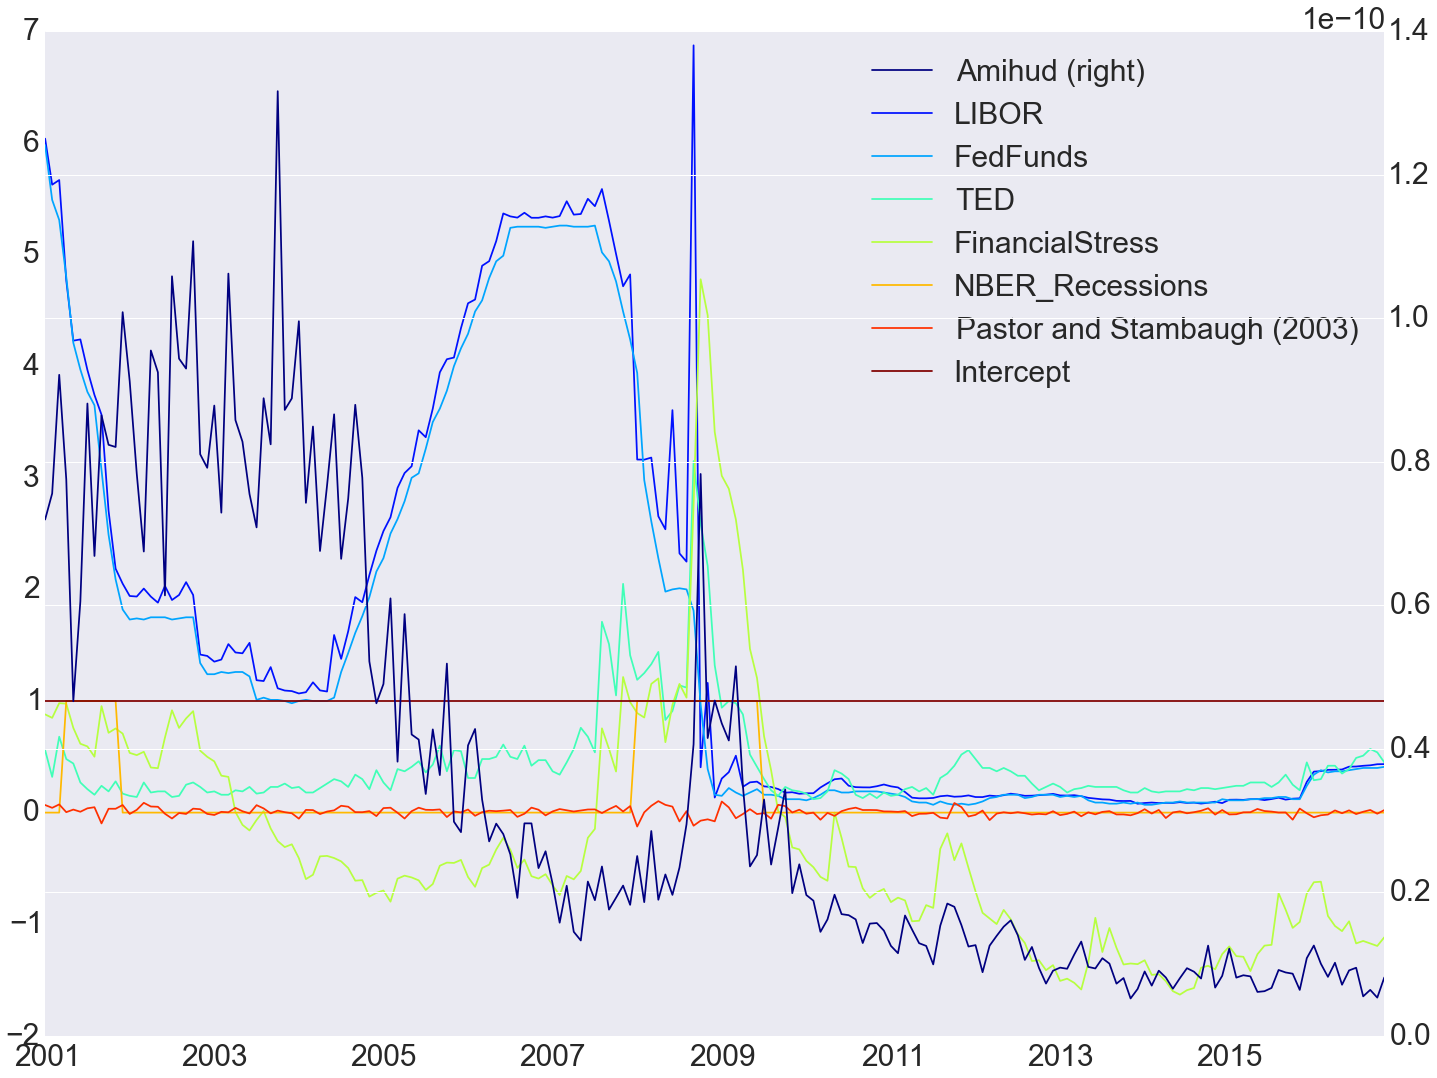

In [28]:
data.plot(colormap='jet',secondary_y='Amihud')

In [43]:
col=['LIBOR', 'TED', 'FinancialStress','NBER_Recessions','Pastor and Stambaugh (2003)']
dd=[]
tt=[]
r2=[]
for i in range(0,5,1):
    reg=['Intercept']
    d=[0]*int(len(col)+1)
    t=[0]*int(len(col)+1)
    reg.append(col[i])
    res=sm.OLS(data.Amihud,data[reg]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    d[0]=res.params.Intercept
    d[i+1]=res.params[col[i]]
    t[0]=res.tvalues.Intercept
    t[i+1]=res.tvalues[col[i]]
    r2.append(res.rsquared_adj)
    tt.append(t)
    dd.append(d)
d=[0]*int(len(col)+1)
t=[0]*int(len(col)+1)
col.append('Intercept')
res=sm.OLS(data.Amihud,data[col]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
d[0]=res.params.Intercept
t[0]=res.tvalues.Intercept
r2.append(res.rsquared_adj)
i=1
for c in col[:-1]: 
    d[i]=res.params[c] 
    t[i]=res.tvalues[c]
    i=i+1
tt.append(t)
dd.append(d)

Note every coefifient is mutliplied 10e10 given the nature of the model.

In [44]:
pd.DataFrame(r2,columns=['Adjusted R^2']).T

,0,1,2,3,4,5
Adjusted R^2,0.067368,-0.001658,0.214482,0.015737,0.009909,0.559649


In [45]:
ind=col[-1:]+col[:-1]
x=(pd.DataFrame(dd,columns=ind)*1e11).round(2)
x['Adjusted R^2']=pd.Series(r2)
x.T.round(2)

,0,1,2,3,4,5
Intercept,2.79,3.70,3.87,3.34,3.46,6.11
LIBOR,0.43,0.00,0.00,0.00,0.00,0.46
TED,0.00,-0.43,0.00,0.00,0.00,-5.29
FinancialStress,0.00,0.00,1.33,0.00,0.00,3.00
NBER_Recessions,0.00,0.00,0.00,1.29,0.00,-2.31
Pastor and Stambaugh (2003),0.00,0.00,0.00,0.00,10.27,-2.41
Adjusted R^2,0.07,-0.00,0.21,0.02,0.01,0.56


In [46]:
pd.DataFrame(tt,columns=ind).round(2).T

,0,1,2,3,4,5
Intercept,8.25,8.05,12.46,10.00,11.44,12.32
LIBOR,3.38,0.00,0.00,0.00,0.00,4.46
TED,0.00,-0.74,0.00,0.00,0.00,-7.46
FinancialStress,0.00,0.00,4.53,0.00,0.00,11.43
NBER_Recessions,0.00,0.00,0.00,1.92,0.00,-3.69
Pastor and Stambaugh (2003),0.00,0.00,0.00,0.00,1.58,-0.53


In [33]:
pd.DataFrame(tt,columns=ind).round(2).T

,0,1,2,3,4,5
Intercept,9.79,11.80,19.16,14.17,15.51,12.32
LIBOR,3.84,0.00,0.00,0.00,0.00,4.46
TED,0.00,-0.83,0.00,0.00,0.00,-7.46
FinancialStress,0.00,0.00,7.27,0.00,0.00,11.43
NBER_Recessions,0.00,0.00,0.00,2.01,0.00,-3.69
Pastor and Stambaugh (2003),0.00,0.00,0.00,0.00,1.70,-0.53


In [22]:
ind2=[]
for col in ind:
    ind2.append(col+' Tstat')
tstat=pd.DataFrame(tt,columns=ind2).round(2)

In [23]:
full=tstat.join(x)

In [24]:
print full.T.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &     0 &      1 &      2 &      3 &      4 &      5 \\
\midrule
Intercept Tstat                   &  9.79 &  11.80 &  19.16 &  14.17 &  15.51 &  12.32 \\
LIBOR Tstat                       &  3.84 &   0.00 &   0.00 &   0.00 &   0.00 &   4.46 \\
TED Tstat                         &  0.00 &  -0.83 &   0.00 &   0.00 &   0.00 &  -7.46 \\
FinancialStress Tstat             &  0.00 &   0.00 &   7.27 &   0.00 &   0.00 &  11.43 \\
NBER\_Recessions Tstat             &  0.00 &   0.00 &   0.00 &   2.01 &   0.00 &  -3.69 \\
Pastor and Stambaugh (2003) Tstat &  0.00 &   0.00 &   0.00 &   0.00 &   1.70 &  -0.53 \\
Intercept                         &  2.79 &   3.70 &   3.87 &   3.34 &   3.46 &   6.11 \\
LIBOR                             &  0.43 &   0.00 &   0.00 &   0.00 &   0.00 &   0.46 \\
TED                               &  0.00 &  -0.43 &   0.00 &   0.00 &   0.00 &  -5.29 \\
FinancialStress                   &  0.00 &   0.00 &   1.33 &   0.00 &   0.00 &   3.00 

#  Table ideas

For one panel I should run correlation matrix on monthly data to see if these are explaining the same thing.  

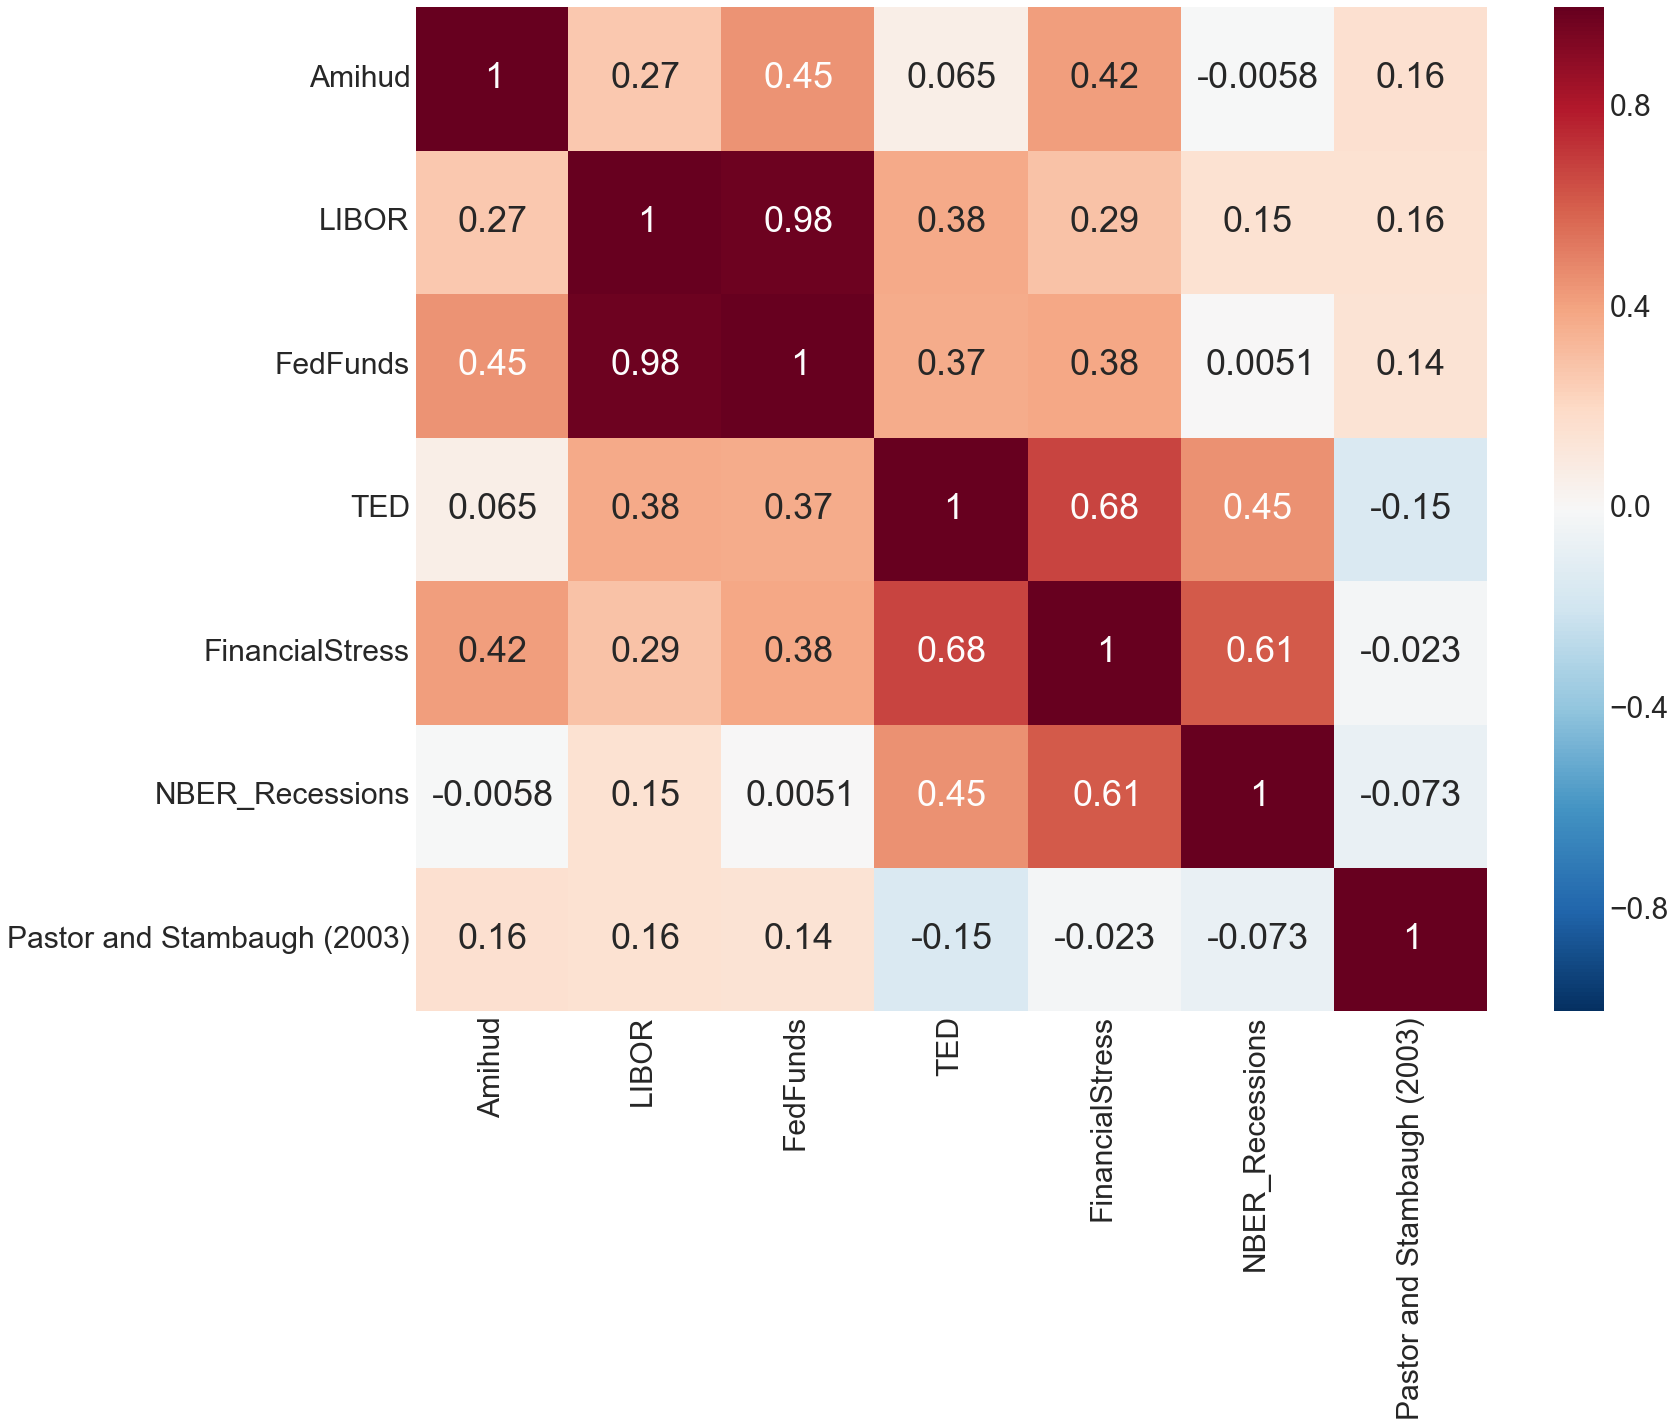

In [29]:
sns.heatmap(df.corr(),annot=True)